Use VGG16 to first extract main features of the image, then capture a style from another image and finally combine them both.

In [35]:
%tensorflow_version 1.x

In [36]:
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

from __future__ import print_function, division
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from datetime import datetime

In [37]:
print(tf.__version__)

1.15.2


## Helper functions

In [38]:
# replace maxpooling with average pooling, just bc it works better this case
# preserves more information
def VGG16_AvgPool(shape):
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)
  new_model = Sequential()
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      new_model.add(AveragePooling2D())
    else:
      new_model.add(layer)
  return new_model

In [39]:
# number of conv layers must be smaller than 13, bc VGG has 13 layers
def VGG16_AvgPool_CutOff(shape, num_convs):
  if num_convs < 1 or num_convs > 13:
    return None

  model = VGG16_AvgPool(shape)
  new_model = Sequential()
  n = 0

  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
    new_model.add(layer)
    if n >= num_convs:
      break

  return new_model 

In [40]:
# reverse of preprocess_input, from BGR to RGB format
def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img

In [41]:
def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x

## Actual training to extract features

In [42]:
path = 'moi.jpg'
img = image.load_img(path)

In [43]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) # just bc network expects even one image to be given in a batch (4D)
x = preprocess_input(x)

In [44]:
# add extra dimension bc network wants batches
batch_shape = x.shape
shape = x.shape[1:]

In [45]:
content_model = VGG16_AvgPool_CutOff(shape, 11)

In [46]:
# input image processed by VGG model becomes target (features)
target = K.variable(content_model.predict(x))

In [47]:
# difference between symbolic variables and target we made
loss = K.mean(K.square(target - content_model.output))

In [48]:
grads = K.gradients(loss, content_model.input)

In [49]:
# function takes numpy array and return numpy array using symbolic variables
get_loss_and_grads = K.function(
    inputs=[content_model.input],
    outputs=[loss] + grads
)

def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0, loss=51.64918518066406
iter=1, loss=23.78459358215332
iter=2, loss=15.948721885681152
iter=3, loss=12.251065254211426
iter=4, loss=9.884446144104004
iter=5, loss=8.171354293823242
iter=6, loss=7.076549530029297
iter=7, loss=6.323402404785156
iter=8, loss=5.736191272735596
iter=9, loss=5.3355793952941895
iter=10, loss=4.909326076507568
iter=11, loss=4.588791370391846
iter=12, loss=4.321441173553467
iter=13, loss=4.0925469398498535
iter=14, loss=3.8957996368408203
iter=15, loss=3.711547374725342
iter=16, loss=3.5483925342559814
iter=17, loss=3.407068967819214
iter=18, loss=3.281643867492676
iter=19, loss=3.1727538108825684
duration:  0:00:43.066322


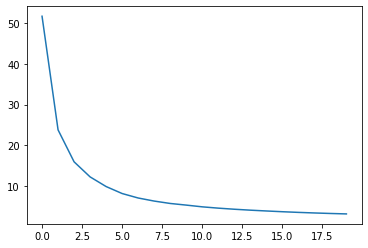

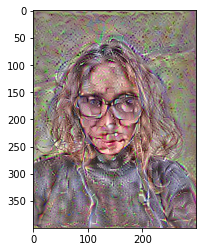

In [50]:
def minimize(fn, epochs, batch_shape):
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))

  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
        func=fn,
        x0=x,
        maxfun=20
    )
    x = np.clip(x, -127, 127)
    print(f"iter={i}, loss={l}")
    losses.append(l)

  print("duration: ", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)  
  plt.imshow(scale_img(final_img[0]))
  plt.show()
  return final_img[0]

img = minimize(get_loss_and_grads_wrapper, 20, batch_shape)

the main details (features, silhouette) of a person are captured

## Style extraction

In [51]:
# autocorrelation
def gram_matrix(img):
  X = K.batch_flatten(K.permute_dimensions(img, (2,0,1)))
  G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements() # gram = (1/N)*XX^T
  return G

In [52]:
def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

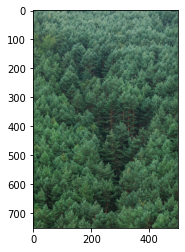

In [63]:
path_style = 'forest.jpg'

img = image.load_img(path_style)
x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

batch_shape = x.shape
shape = x.shape[1:]

plt.imshow(img)

image from which the pattern needs to be extracted

In [64]:
vgg = VGG16_AvgPool(shape)

# output from multiple layers
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')
]

multi_output_model = Model(vgg.input, symbolic_conv_outputs)
style_layers_outputs = [K.variable(y) for y in multi_output_model.predict(x)]

# style loss
loss = 0
for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs):
  loss += style_loss(symbolic[0], actual[0])

grads = K.gradients(loss, multi_output_model.input)

In [65]:
get_loss_and_grads = K.function(
    inputs=[multi_output_model.input],
    outputs=[loss] + grads
)

def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0, loss=1913.341796875
iter=1, loss=36.99612808227539
iter=2, loss=10.710846900939941
iter=3, loss=6.4798455238342285
iter=4, loss=4.545506477355957
iter=5, loss=3.839268207550049
iter=6, loss=3.8391714096069336
iter=7, loss=3.8391714096069336
iter=8, loss=3.8391714096069336
iter=9, loss=3.8391714096069336
iter=10, loss=3.8391714096069336
iter=11, loss=3.8391714096069336
iter=12, loss=3.8391714096069336
iter=13, loss=3.8391714096069336
iter=14, loss=3.8391714096069336
iter=15, loss=3.8391714096069336
iter=16, loss=3.8391714096069336
iter=17, loss=3.8391714096069336
iter=18, loss=3.8391714096069336
iter=19, loss=3.8391714096069336
duration:  0:01:15.652531


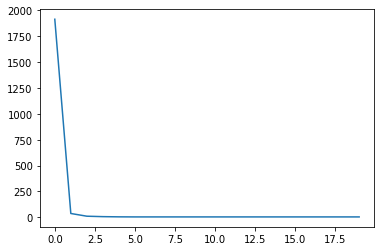

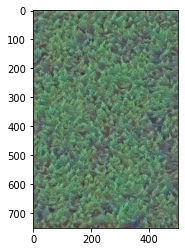

In [66]:
final_img = minimize(get_loss_and_grads_wrapper, 20, batch_shape)

the style is captured but without global details (features)

## Apply extracted style to extracted details

In [67]:
def load_and_preprocess(path, shape=None):
  img = image.load_img(path, target_size=shape)
  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return x

In [68]:
content_img = load_and_preprocess(path)
h, w = content_img.shape[1:3]

style_img = load_and_preprocess(path_style, (h,w))

batch_shape = content_img.shape
shape = content_img.shape[1:]

In [69]:
vgg = VGG16_AvgPool(shape)

content_model = Model(vgg.input, vgg.layers[13].get_output_at(0))
content_target = K.variable(content_model.predict(content_img))

symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')
]

style_model = Model(vgg.input, symbolic_conv_outputs)
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]
style_weights = [1,2,3,4,5]


In [70]:
# total loss as a sum of content + style loss
loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  loss += w * style_loss(symbolic[0], actual[0])

In [71]:
grads = K.gradients(loss, vgg.input)

get_loss_and_grads = K.function(
    inputs = [vgg.input],
    outputs = [loss] + grads
)

def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0, loss=7307.6162109375
iter=1, loss=631.3367919921875
iter=2, loss=328.22711181640625
iter=3, loss=250.2594757080078
iter=4, loss=216.79641723632812
iter=5, loss=193.25453186035156
iter=6, loss=180.4641571044922
iter=7, loss=170.5751953125
iter=8, loss=163.58663940429688
iter=9, loss=158.63259887695312
iter=10, loss=154.8277130126953
iter=11, loss=151.90963745117188
iter=12, loss=149.71548461914062
iter=13, loss=147.7628631591797
iter=14, loss=146.21836853027344
iter=15, loss=144.93141174316406
iter=16, loss=143.77064514160156
iter=17, loss=142.79356384277344
iter=18, loss=141.954345703125
iter=19, loss=141.21583557128906
duration:  0:00:47.515655


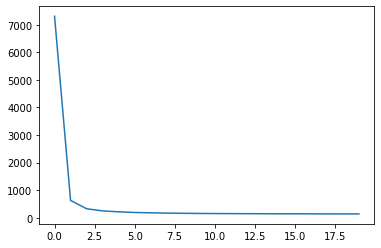

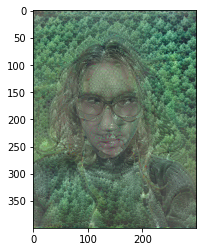

In [72]:
final_img = minimize(get_loss_and_grads_wrapper, 20, batch_shape)